# Variational Quantum Eigensolver
#### This notebook demonstrates the use on variatonal quantum eigensolver (VQE) in finding the ground state of a qubit Hamiltonian. 

Importing used libraries

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp, state_fidelity
from qiskit.visualization import circuit_drawer
from IPython.display import display, Math
from scipy.optimize import minimize
import numpy as np
import numpy.random as npr
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Initializing random Hamiltonians
We first define a function that allows us to create random $N$ qubit Hamiltonians by combining arbitrarily weighted Pauli operators. Additionally we define a function that prints these Hamiltonians nicely.

In [2]:
# Function to generate a random Hamiltonian
def random_hamiltonian(n_qubits: int, num_terms: int = 3, seed = None) -> SparsePauliOp:
    """
    Generates a random Hamiltonian for a given number of qubits using SparsePauliOp.
    
    Parameters:
        n_qubits (int): Number of qubits.
        num_terms (int): Number of random Pauli terms in the Hamiltonian.
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        SparsePauliOp: A random Hamiltonian represented as a sparse sum of Pauli operators.
    """
    if seed is not None:
        np.random.seed(seed)
    
    pauli_ops = ['X', 'Y', 'Z']
    hamiltonian_terms = []
    
    for _ in range(num_terms):
        # Generate a random Pauli string of length n_qubits
        pauli_string = ''.join(np.random.choice(pauli_ops, size=n_qubits))
        
        # Assign a random coefficient between 0 and 1
        coefficient = np.random.uniform(0, 1)
        
        hamiltonian_terms.append((pauli_string, np.round(coefficient, 1)))
    
    # Create a SparsePauliOp from the generated terms
    return SparsePauliOp.from_list(hamiltonian_terms)

def print_hamiltonian(hamiltonian: SparsePauliOp) -> None:
    """
    Displays the LaTeX representation of a given Hamiltonian using IPython display.
    
    Parameters:
        hamiltonian (SparsePauliOp): The Hamiltonian to be formatted in LaTeX.
    """
    latex_str = r"H = "
    terms = []
    
    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        pauli_str = pauli.to_label()
        if coeff.real>0:
            formatted_coeff = f"+{coeff.real:.1f}"  # Remove complex part if it's zero
        else:
            formatted_coeff = f"{coeff.real:.1f}"  # Remove complex part if it's zero
        terms.append(f"{formatted_coeff} \\cdot {pauli_str}")
    
    latex_str += " ".join(terms)
    # latex_str = unicode_to_latex(latex_str)  # Encode properly for LaTeX
    
    # Use IPython display to render LaTeX properly
    display(Math(latex_str))

Above functions can be tested here by changing the variables `n_qubits`, `n_terms` and `seed`

In [ ]:
# Example Usage
n_qubits = 3
n_terms = 3
seed = 16     # With seed defined to some integer the random number generator always produces same distribution
              # with seed = None each run produces new random distribution 
hamiltonian = random_hamiltonian(n_qubits, num_terms=n_terms, seed=seed)
print('Random Hamiltonian =', hamiltonian)
print_hamiltonian(hamiltonian)

Random Hamiltonian = SparsePauliOp(['YZY', 'XYX', 'XZX'],
              coeffs=[0.1+0.j, 0.2+0.j, 0.9+0.j])


<IPython.core.display.Math object>

#### Ansatz circuit

In a VQE the ansatz circuit represents the quantum state $| \psi(\theta) \rangle$ that approximates the ground state of the target Hamiltonian. It is consists of parameterized gates, $R_y(\theta_i)$ in our case, and of entangling gates for which we use CNOT gates. For each parameterized gate the parameter $\theta_i$ is iteratively optimized to minimize the expectation value of the Hamiltonian. Here we define a function that returns an ansatz circuit and its parameters for $N$ qubits and $L$ layers. Generally each layer improves the expressibility of the circuit whilst increasing the computational complexity.

In [5]:
def ansatz_circ(n_qubits: int, layers: int) -> tuple[list[Parameter], QuantumCircuit]:
    """
    Generates a parameterized ansatz circuit for the VQE.
    
    Args:
        n_qubits (int): Number of qubits in the circuit.
        layers (int): Number of layers of rotation and entanglement gates.
    
    Returns:
        tuple[list[Parameter], QuantumCircuit]:
            - A list of trainable parameters.
            - The constructed ansatz quantum circuit.
    """
    
    # Initialize an empty quantum circuit with n_qubits
    circ = QuantumCircuit(n_qubits)
    params = []  # List to store the trainable parameters
    
    # Initial layer of single-qubit rotations (R_y gates) with unique parameters
    for i in range(n_qubits):
        angle = Parameter(f'θ_{i}0')
        params.append(angle)
        circ.ry(angle, i)  # Apply R_y rotation to each qubit
    
    # Layers of entanglement (CNOT gates) followed by R_y rotations
    for l in range(layers):
        
        # Apply cyclic nearest-neighbor CNOT entanglement
        for i in range(n_qubits):
            circ.cx(i, np.mod(i+1, n_qubits))
        
        circ.barrier()
        
        #New round of R_y rotations with new trainable parameters
        for i in range(n_qubits):
            angle = Parameter(f'θ_{i}{l+1}')
            params.append(angle)
            circ.ry(angle, i)
    
    return params, circ

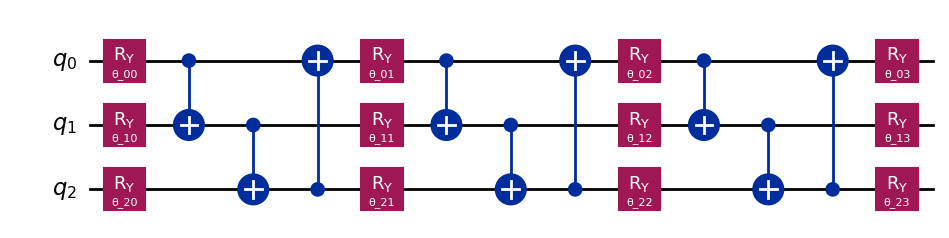

In [6]:
n_layers = 3
params, circ = ansatz_circ(n_qubits, n_layers)
n_params = len(params)
circ.draw(output="mpl", plot_barriers=False)

## Energy computation

In a real VQE we would use a quantum computer to estimate the energy $E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle$ with a finite number of shots. This would produce some amount of shot noise in the energy estimation. We try the noisy simulation later but first we simplify the problem by computing $E(\theta)$ directly, thus removing any noise effects.

In [7]:
def energy(param_values: list[float], params: list[Parameter], hamiltonian: SparsePauliOp) -> float:
    """
    Computes the energy of a given Hamiltonian in the state produced by the circuit.
    
    Args:
        param_values (list[float]): A list of parameter values for the circuit.
        params (list[Parameter]): The list of parameterized circuit parameters.
        hamiltonian (SparsePauliOp): The Hamiltonian whose expectation value is being computed.
        circuit (QuantumCircuit): The ansatz circuit used to prepare the quantum state.
    
    Returns:
        float: The computed energy expectation value for the given parameter values.
    """ 
    # Bind parameter values to the circuit
    binds = {p: v for p, v in zip(params, param_values)}
    
    # Generate the quantum state from the parameterized circuit
    state = Statevector.from_instruction(circ.assign_parameters(binds))

    # Compute the expectation value of the Hamiltonian in this state
    E = state.expectation_value(hamiltonian).real
    return E

Example usage: we generate a random distribution of $\theta_i$ values and calculate the energy with them 

In [8]:
test_values = npr.uniform(0, 2*np.pi, len(params))
print('Energy for parameter values', test_values, 'is', energy(param_values=test_values, params=params, hamiltonian=hamiltonian))

Energy for parameter values [5.3063817  4.30725952 1.07456516 3.73427913 3.54330641 4.56750599
 2.21201992 4.46728877 2.27159099 0.55757707 1.93615188 4.44261542] is -0.3891336316977919


## Gradient calculation

In order to use gradient-based optimization methods such as gradient descent, we need to be able to find gradients of $E(\theta)$ w.r.t. the parameters $\theta$. Since the parameterized rotation gates are sinusoidally dependent on $\theta_i$ we can exploit parameter shift rule for the gradient calculation. Parameter shift rule states that
$$
\nabla E(\theta_i)= \frac{1}{2} \left( E(\theta_i + \frac{\pi}{2}) - E(\theta_i - \frac{\pi}{2}) \right)
$$. 
This is defined as a function below.

In [9]:
def gradient(param_values: list[float], params: list[Parameter], hamiltonian: SparsePauliOp) -> list[float]:
    '''
    Computes the gradient of the energy with respect to the parameters using the finite difference method.
    
    Args:
        param_values (list[float]): A list of parameter values for the circuit.
    
    Returns:
        list[float]: returns the gradient computed throught parameter-shift rule
    '''
    
    # Initialize gradient array with zeros
    gradient = np.zeros_like(param_values)
    
    # Shift value for numerical differentiation
    shift = np.pi / 2
    
    # Compute gradient using the parameter shift rule
    for i in range(len(param_values)):
        # Create shifted parameter arrays
        shifted_up = np.copy(param_values)
        shifted_down = np.copy(param_values)
        
        # Apply positive and negative shifts to the ith parameter
        shifted_up[i] += shift
        shifted_down[i] -= shift
        
        # Compute the finite difference approximation of the derivative
        grad = 0.5 * (energy(shifted_up, params, hamiltonian) - energy(shifted_down, params, hamiltonian))
        
        # Store the gradient value
        gradient[i] = grad
    
    return gradient

## Optimization

We will use a simple gradient descent algorithm for optimization. That is, we update the parameters
$$
\theta \leftarrow \theta - \epsilon \nabla E(\theta)
$$
until the energy $E(\theta)$ reaches a minimum.

In [10]:
def gradient_descent(params: list[Parameter], hamiltonian: SparsePauliOp, steps=100, lr=0.1) -> tuple[list[float], float]:
    x = npr.uniform(0, 2*np.pi, n_params)
    energies = [energy(x, params, hamiltonian)]
    for _ in range(steps):
        x -= lr*gradient(x, params, hamiltonian)
        energies.append(energy(x, params, hamiltonian))
    return energies, x

## Results

The noisless optimization can be tested below. One can try to match the precise ground state energy by tweaking the number of ansatz layers (`n_layers`), number of steps (`steps`) and the learning (`lr`) rate. The gradient descent method may converge to local minima instead of the ground state for some random $H$, displaying the limitations of this method. 

<IPython.core.display.Math object>

For learning rate = 0.1, the optimization energy is -0.9819661870391765
For learning rate = 0.5, the optimization energy is -0.9999822898225047
For learning rate = 0.9, the optimization energy is -0.9998773167473961
For learning rate = 1.3, the optimization energy is -0.6196138055791176
For learning rate = 1.7, the optimization energy is -0.40111320354512536
Precise ground state energy is -1.019803902718557


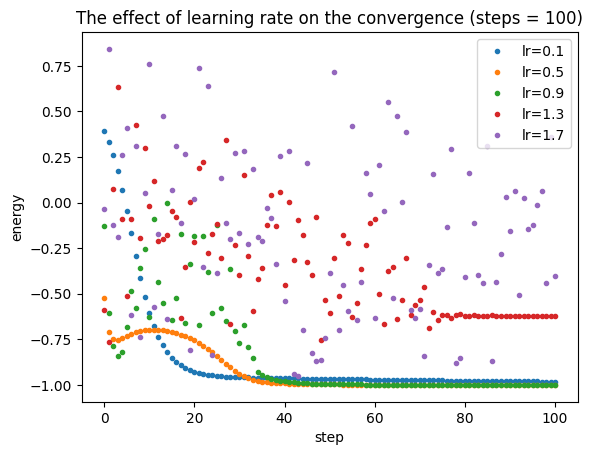

In [11]:

n_qubits = 3
n_terms = 3
seed = 16    

H = random_hamiltonian(n_qubits, num_terms=n_terms, seed=seed)

print_hamiltonian(H)

n_layers = 2
params, circ = ansatz_circ(n_qubits, n_layers)
n_params = len(params)

for lr in range(1, 20, 4):
    lr /= 10
    energies, final_values = gradient_descent(params=params, hamiltonian=H, steps=100, lr=lr)
    print(f'For learning rate = {lr}, the optimization energy is', energies[-1])
    plt.plot(energies, '.', label=f'lr={lr}')
plt.xlabel('step')
plt.ylabel('energy')
plt.legend()
plt.title('The effect of learning rate on the convergence (steps = 100)')

eigenvalues, eigenvectors = linalg.eigh(H.to_matrix())
print('Precise ground state energy is', eigenvalues[0])

Below is defined functions that implement more realistic setup using noisy quantum simulator.

In [12]:

def get_expectation(
        param_values: list[float],
        params: list[Parameter],
        circuit: QuantumCircuit,
        backend,
        hamiltonian: SparsePauliOp,
        shots: int = 500
    ):
    """
    Executes the circuit with given parameters and computes the expectation value.
    
    Args:
        param_values (list): List of parameter values.
        params (list): List of circuit parameters.
        circuit (QuantumCircuit): Parameterized ansatz circuit.
        backend (Backend): Noisy quantum backend simulator.
        shots (int): Number of measurement shots.
    
    Returns:
        float: Computed expectation value of the Hamiltonian.
    """
    binds = {p: v for p, v in zip(params, param_values)}
    bound_circuit = circuit.assign_parameters(binds)
    bound_circuit.measure_all()
    transpiled_circuit = transpile(bound_circuit, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    counts = job.result().get_counts()
    
    expectation = 0
    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        eigenvalues = np.array([(-1)**(sum(int(bit) for bit in key)) for key in counts.keys()])
        probabilities = np.array([val / shots for val in counts.values()])
        expectation += coeff * np.dot(eigenvalues, probabilities)

    return expectation.real


In [13]:
def vqe_optimization(params: list[Parameter], ansatz: QuantumCircuit, hamiltonian: SparsePauliOp, shots: int = 500):
    """Runs the full VQE optimization loop using a noisy simulator."""
    backend = Aer.get_backend('aer_simulator')
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.25, 1), ["rx", "ry", "rz"])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.5, 2), ["cx"])

    initial_params = np.random.rand(len(params))
    
    def cost_function(param_values):
        return get_expectation(param_values, params, ansatz, backend, hamiltonian, shots)
    
    result = minimize(cost_function, initial_params, method='COBYLA')
    return result

The below code demonstrates how the number of shots affects the accuracy of the VQE optimization. To speed up calculations we choose only a two qubit random Hamiltonian.

<IPython.core.display.Math object>

For shots=25 attempt 0, noisy optimization energy is -1.1039999999999999
For shots=25 attempt 1, noisy optimization energy is -1.008
For shots=25 attempt 2, noisy optimization energy is -1.2
For shots=25 attempt 3, noisy optimization energy is -1.2
For shots=25 attempt 4, noisy optimization energy is -1.008
For shots=25 attempt 5, noisy optimization energy is -1.1039999999999999
For shots=25 attempt 6, noisy optimization energy is -1.2
For shots=125 attempt 0, noisy optimization energy is -1.1808
For shots=125 attempt 1, noisy optimization energy is -1.2
For shots=125 attempt 2, noisy optimization energy is -1.0848
For shots=125 attempt 3, noisy optimization energy is -1.1808
For shots=125 attempt 4, noisy optimization energy is -1.2
For shots=125 attempt 5, noisy optimization energy is -1.1423999999999999
For shots=125 attempt 6, noisy optimization energy is -1.2
For shots=225 attempt 0, noisy optimization energy is -1.2
For shots=225 attempt 1, noisy optimization energy is -1.1786666

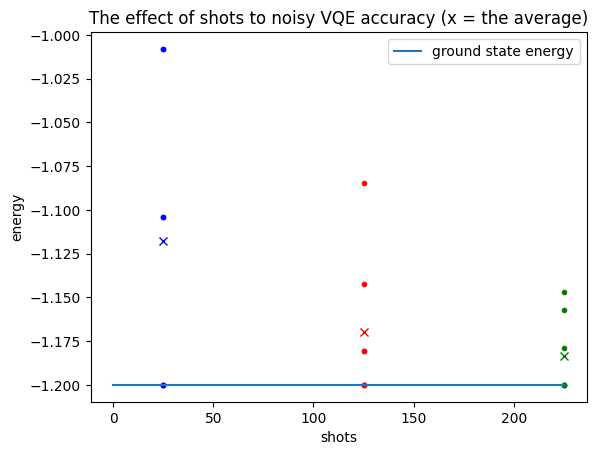

In [19]:
n_qubits = 2
n_terms = 2
seed = 2     
H = random_hamiltonian(n_qubits, num_terms=n_terms, seed=seed)

print_hamiltonian(H)


n_layers = 1
params, circ = ansatz_circ(n_qubits, n_layers)
result = vqe_optimization(params, circ, H)


colors = ['b', 'r', 'g', 'orange', 'pink']
i = 0
results_for_shots = []
for shots in range(25, 226, 100):
    # legends.append(f"shots={shots}")
    for attempt in range(7):
        result = vqe_optimization(params, circ, H, shots)
        results_for_shots.append(result.fun)
        print(f"For shots={shots} attempt {attempt}, noisy optimization energy is", result.fun)
        plt.plot(shots, result.fun, '.', color=colors[i])
    plt.plot(shots, np.average(results_for_shots), 'x', color=colors[i])
    results_for_shots = []
    i+=1


plt.xlabel('shots')
plt.ylabel('energy')
plt.title('The effect of shots to noisy VQE accuracy (x = the average)')


eigenvalues, eigenvectors = linalg.eigh(H.to_matrix())
print('Precise ground state energy is', eigenvalues[0])
plt.plot(np.linspace(0, 225, 200), eigenvalues[0]*np.ones(200), label='ground state energy')
plt.legend()